In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from CNN import Modified_VGG16

In [ ]:
from keras.optimizers import Adam
import keras

In [2]:
"""
training_data, validation_data = keras.preprocessing.image_dataset_from_directory(
    './dataset',  # the path to the dataset
    labels='inferred',  # keep the original folder structure (class names)
    label_mode='int',   # use integer labels
    class_names=None,   # class names will be inferred from the folder structure
    color_mode='grayscale',   # the images are MRI scans in grayscale
    batch_size=32,  # images will be fed in batches of 32
    image_size=(224, 224),  # images will be resized to 224x224 pixels - the input size of the VGG16 model
    validation_split=0.2,   # 20% of the images will be used for validation, 80% for training
    subset='both',  # the data generator will return training data
    shuffle=True,   # shuffle the images randomly before training - this is important to avoid overfitting
    seed=42         # provide a seed to ensure no overlap between training and validation subsets
)

print(training_data.class_names)
print(training_data)

"""

"\ntraining_data, validation_data = keras.preprocessing.image_dataset_from_directory(\n    './dataset',  # the path to the dataset\n    labels='inferred',  # keep the original folder structure (class names)\n    label_mode='int',   # use integer labels\n    class_names=None,   # class names will be inferred from the folder structure\n    color_mode='grayscale',   # the images are MRI scans in grayscale\n    batch_size=32,  # images will be fed in batches of 32\n    image_size=(224, 224),  # images will be resized to 224x224 pixels - the input size of the VGG16 model\n    validation_split=0.2,   # 20% of the images will be used for validation, 80% for training\n    subset='both',  # the data generator will return training data\n    shuffle=True,   # shuffle the images randomly before training - this is important to avoid overfitting\n    seed=42         # provide a seed to ensure no overlap between training and validation subsets\n)\n\nprint(training_data.class_names)\nprint(training_da

We should proceed another way to preprocess the data (and especially load it). Since we are not yet quite familiar with TensorFlow or Keras, we will import the data ourselves and preprocess it.

First, let's store the labels in a variable.

In [10]:
dataset_path = "./dataset"

class_names = os.listdir(dataset_path)
class_names = sorted(class_names)
class_names.remove('.DS_Store')
nb_classes = len(class_names)
print(f'The dataset contains {nb_classes} classes: {class_names}')

The dataset contains 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Now, we want to load the images. To do so, we will use the `cv2` library. We will load the images and resize them to 224x224 pixels. We will also normalize the images by dividing them by 255.

Finally, we will split the data into training and validation sets.

In [11]:
image_size = (224, 224)
batch_size = 32

X = []
y = []

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        img = cv2.resize(img, image_size)  # Resize to 224x224 (image size of VGG16)
        img = img / 255.0  # Normalize pixel value to [0, 1]
        X.append(img)
        y.append(class_name)


In [15]:
# Convert to numpy arrays
X = np.array(X, dtype=np.float32).reshape(-1, 224, 224, 1)  # Reshape for CNN
y_label = np.array(y).reshape(-1, 1)


In [18]:
print(y_label.shape)

(5712, 1)


In [19]:
# Encode class labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y_label)  # Convert class names to binary

In [20]:
print(X.shape)
print(y_label.shape)
print(y.shape)
print(y)

(5712, 224, 224, 1)
(5712, 1)
(5712, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


Shape of an image is (224, 224, 1)


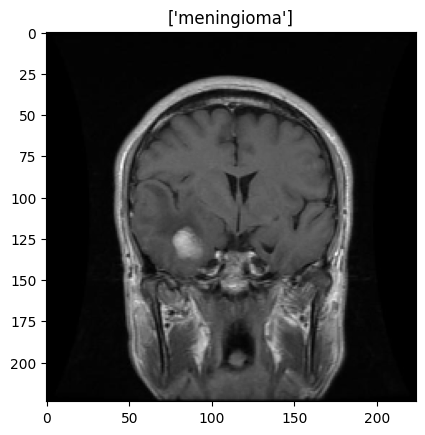

In [21]:
# Display a random image
rd = np.random.randint(0, len(X))
image = X[rd]
label = y_label[rd]
print(f'Shape of an image is {image.shape}')
plt.imshow(image, cmap='gray')
plt.title(label)
plt.show()

The data has now been preprocessed, which means :
- the images have all been resied to the shape (224 x 224)
- the pixel values have been normalised (/255)
- the images have been loaded in greyscale

But we now need to determine which metric is of importance to assess the performance of our model. This means doing some EDA, notably checking the class distribution. If it is balanced, assessing the performance of the model with accuracy should do.

Glioma: 1321
Meningioma: 1339
No Tumor: 1595
Glioma: 1457


<function matplotlib.pyplot.show(close=None, block=None)>

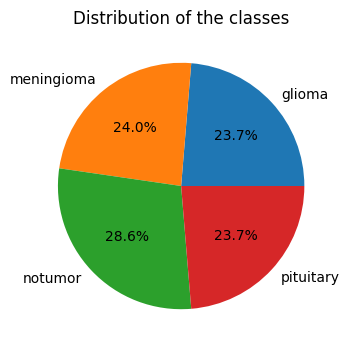

In [27]:
glioma_count = (y_label == 'glioma').sum()
meningioma_count = (y_label == 'meningioma').sum()
notumor_count = (y_label == 'notumor').sum()
pituitary_count = (y_label == 'pituitary').sum()

print(f"Glioma: {glioma_count}")
print(f"Meningioma: {meningioma_count}")
print(f"No Tumor: {notumor_count}")
print(f"Glioma: {pituitary_count}")

distribution = [glioma_count, meningioma_count, notumor_count, glioma_count]

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

fig = plt.figure(figsize=(6, 4))
plt.pie(distribution, labels=class_names, autopct=lambda pct: func(pct, distribution))
plt.title("Distribution of the classes")
plt.show


The class distribution is quite well balanced. This means we can theoretically assess the model performance with the accuracy metric. We will then plot the confusion matrix to ensure that the prediction errors are well balanced. If not, we will reassess this hypothesis.

We can now split the data into two datasets : the training set and the testing set.

In [28]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (5712, 224, 224, 1), y shape: (5712, 4)


In [29]:
# First split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [30]:
# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Here, the data is shuffled and stritified. That means we ensure robustness, while keeping our class distribution as balanced as the original data.

Now we are ready to train, then test, our neural network. For this model, we will first implement a VGG-16 CNN.

In [32]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4569, 224, 224, 1)
X_val shape: (571, 224, 224, 1)
X_test shape: (572, 224, 224, 1)
y_train shape: (4569, 4)
y_val shape: (571, 4)
y_test shape: (572, 4)


In [33]:
# Quick tests to ensure the data is consistent and correctly split

assert len(X) == len(y), "X and y should be of same length" # If not, some images will be missing a label
assert len(X_train) == len(y_train), "X_train and y_train must be of same length"
assert len(X_val) == len(y_val), "X_val and y_val must be of same length"
assert len(X_test) == len(y_test), "X_test and y_test must be of same length"
assert len(X_train) + len(X_test) + len(X_val) == len(X), "X must be on length len(X_train) + len(X_test)"

The training data is ready to be fed to the CNN to train the model.

In [38]:
optimizer = Adam(learning_rate=0.001)
Modified_VGG16.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy', 'precision', 'recall', 'f1_score', 'categorical_crossentropy', 'AUC'])

In [39]:
Modified_VGG16.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,275,780 (512.22 MB)

 Trainable params: 134,275,780 (512.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = Modified_VGG16.fit(
    X_train, y_train,  # Training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=20,  # Number of training iterations
    batch_size=batch_size,  # Number of samples per training batch
    verbose=1  # Shows training progress
)


Epoch 1/20
